# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [9]:
def camera_calibration(images, nx, ny, show=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,4,0),(6,5,0),...
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Make a list of calibration images
    images = glob.glob(images)

    # Step through the list and search for chessboard corners
    for fname in images:
        
        img = cv2.imread(fname)
        corner_img = np.copy(img)
    
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            if show:
                # Draw and display the corners
                cv2.drawChessboardCorners(corner_img, (nx,ny), corners, ret)
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
                ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                ax1.set_title('Original Image', fontsize=18)
                ax2.imshow(cv2.cvtColor(corner_img, cv2.COLOR_BGR2RGB))
                ax2.set_title('With Corners', fontsize=18)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)
    return mtx, dist

Camera successfully calibrated.


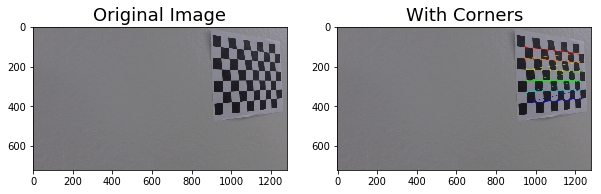

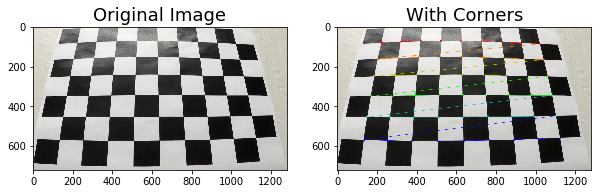

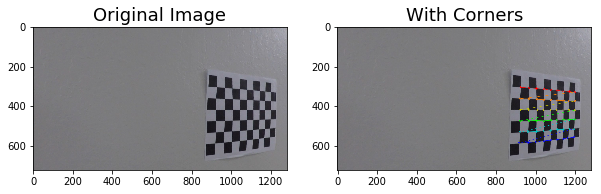

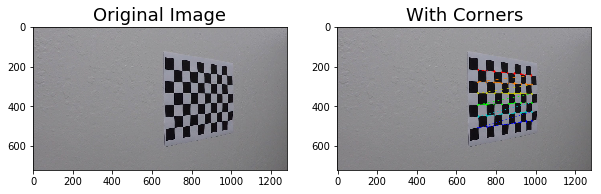

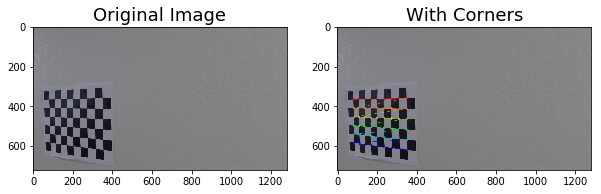

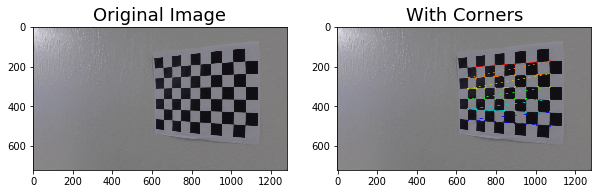

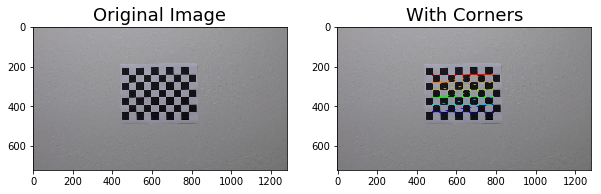

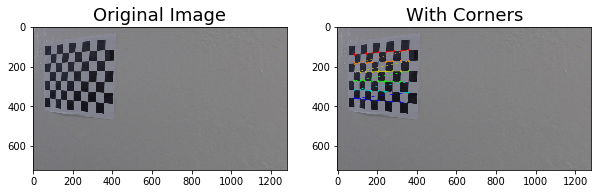

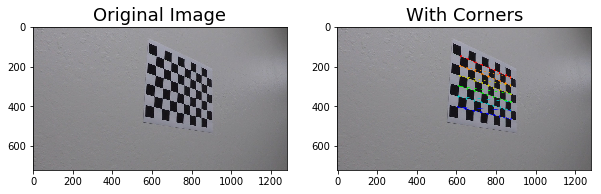

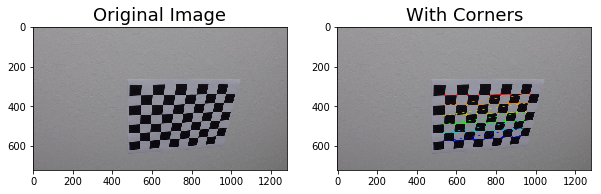

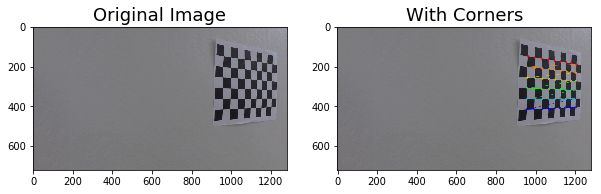

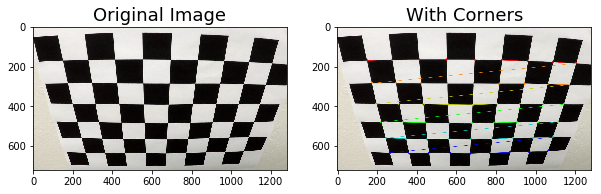

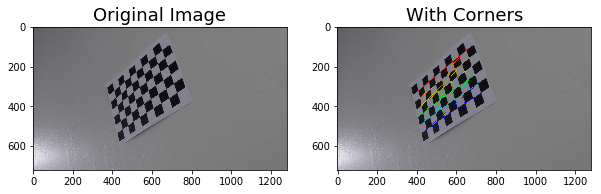

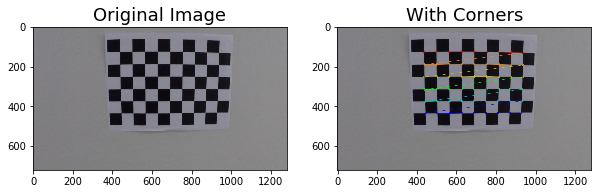

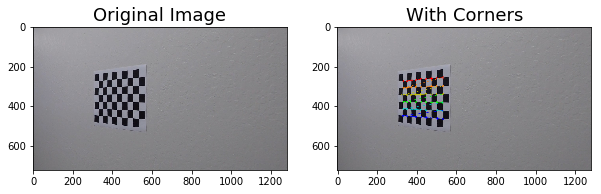

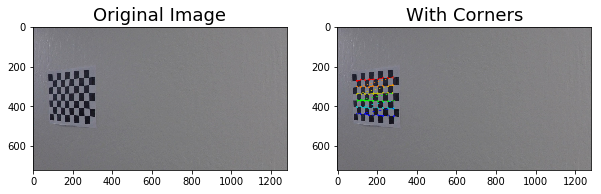

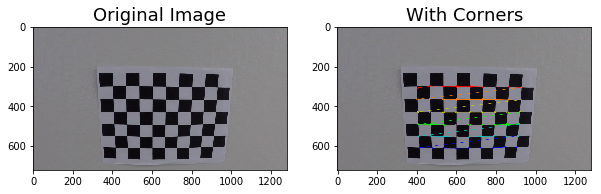

In [11]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

CALIBRATION_IMAGES = 'camera_cal/calibration*.jpg'

# number of chessboard corners
nx = 9
ny = 6

mtx, dist = camera_calibration(CALIBRATION_IMAGES, nx, ny, show=True)

## Apply a distortion correction to raw images.

In [12]:
def undistort(img, mtx, dist, undist_image='', show=False):
    # Test undistortion on an image
    img_size = (img.shape[1], img.shape[0])
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if undist_image != '':
        mpimg.imsave(undist_image,undist)

    # Visualize undistortion
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=30)

    return undist

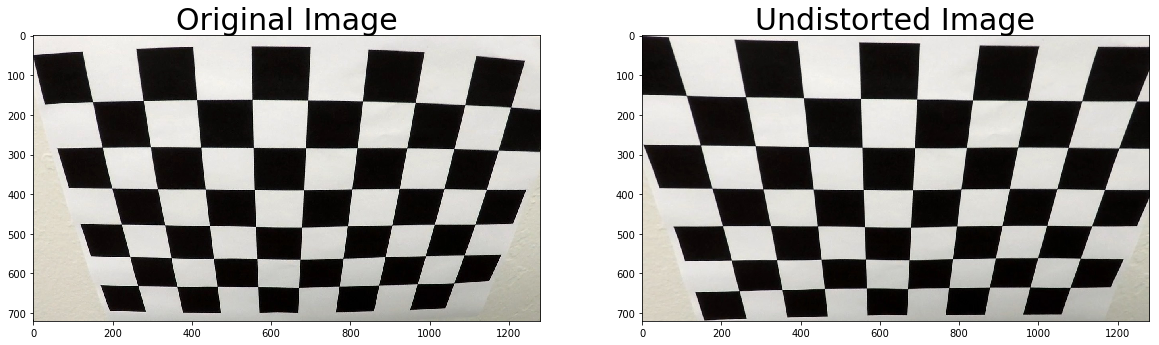

In [15]:
cal_img = cv2.imread('camera_cal/calibration2.jpg')
cal_img = cv2.cvtColor(cal_img, cv2.COLOR_BGR2RGB)
_ = undistort(cal_img, mtx, dist, show=True)

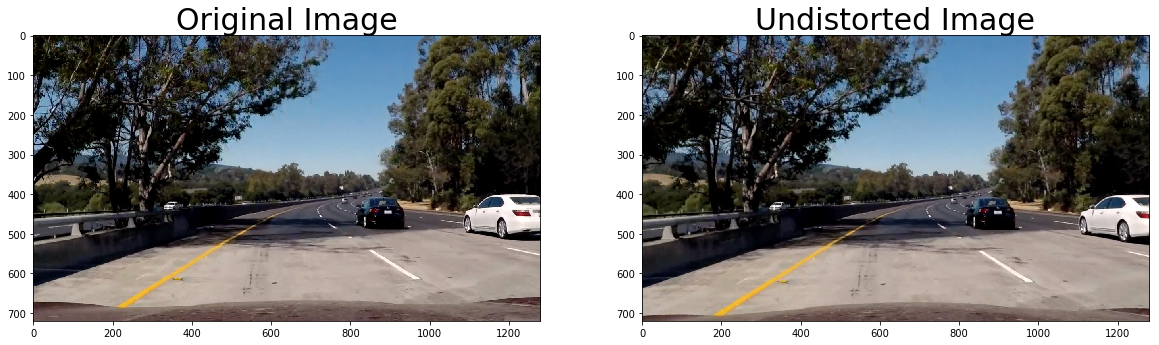

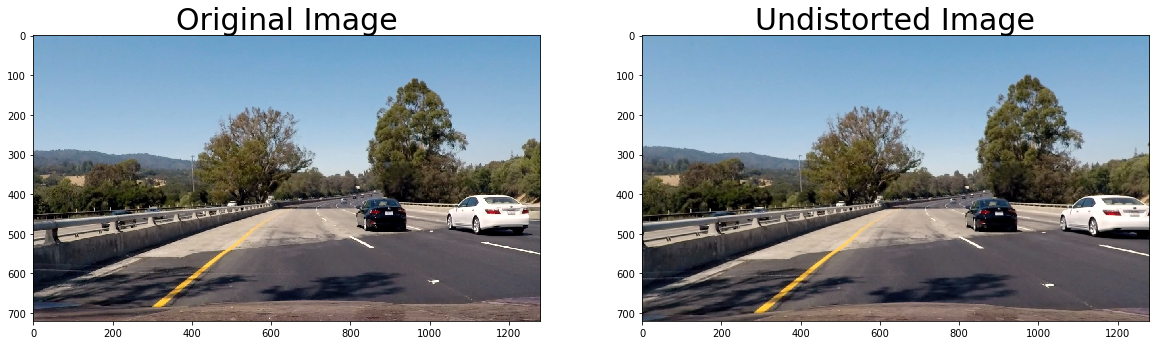

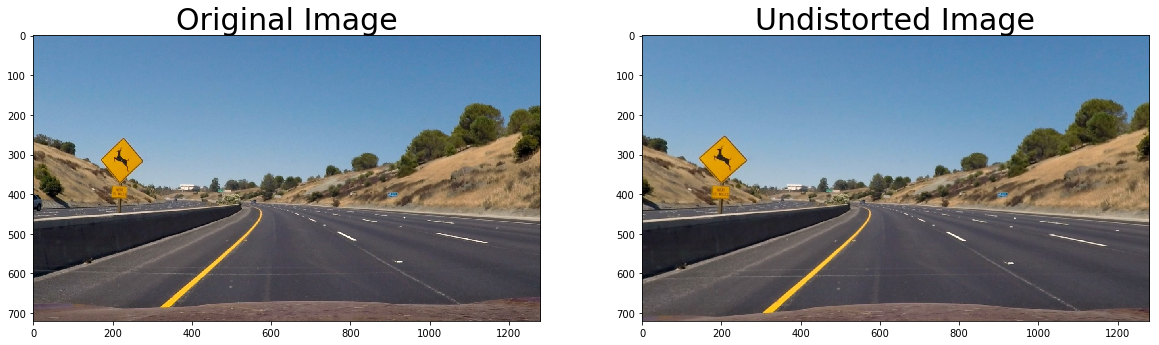

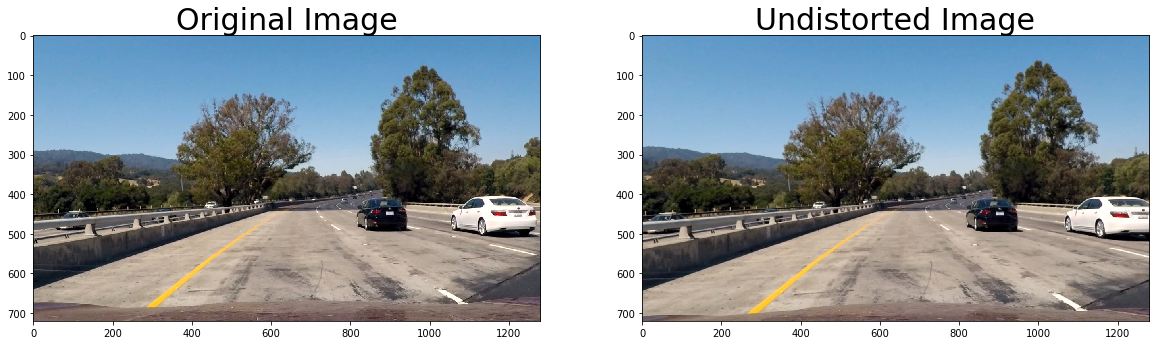

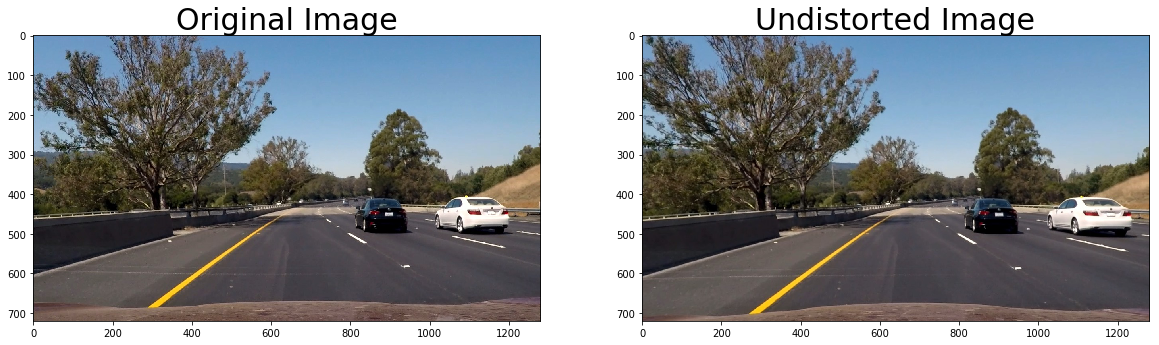

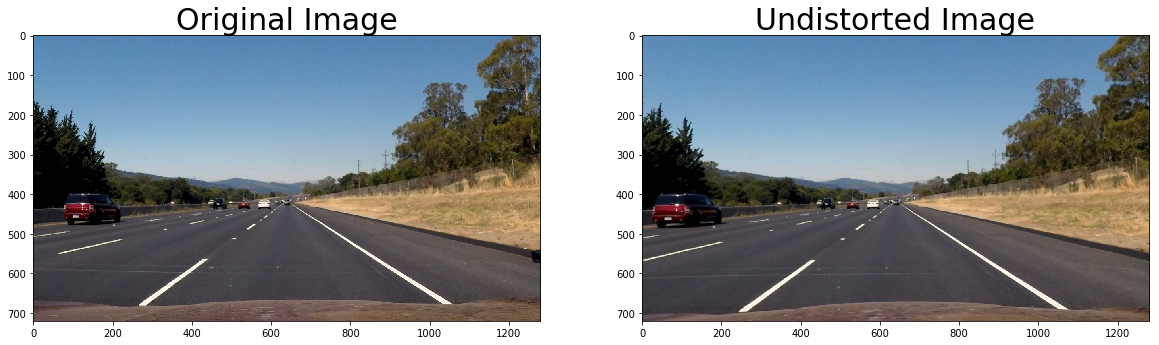

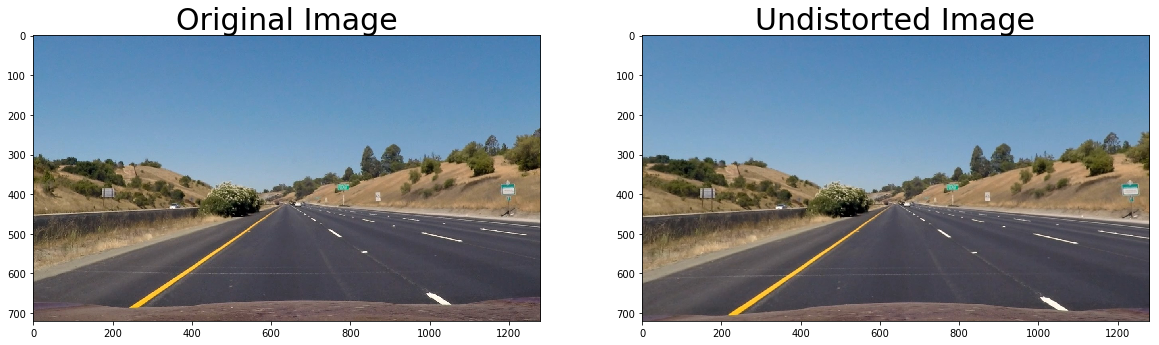

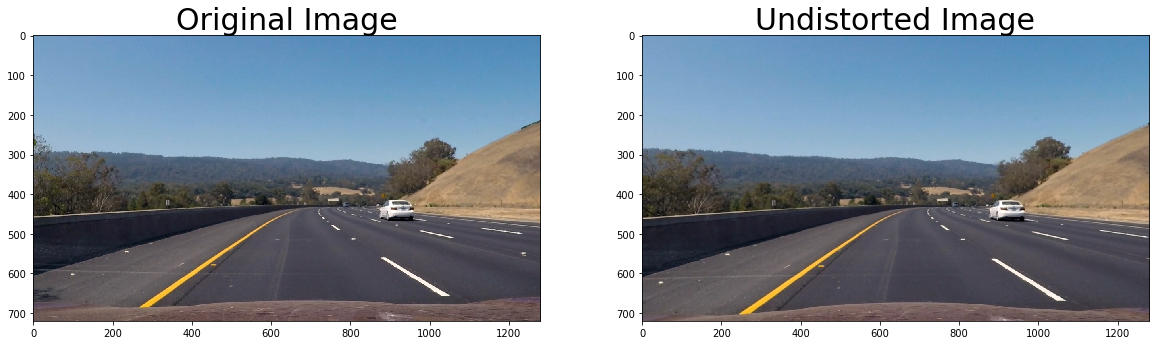

In [16]:
ORIGINAL_IMAGES = 'test_images/*.jpg'
images = glob.glob(ORIGINAL_IMAGES)
for fname in images:
    imgs = cv2.imread(fname)
    imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
    _ = undistort(imgs, mtx, dist, fname.replace('test_images','output_images').replace('.jpg', '_undist.jpg'), show=True)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [19]:
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100), show = False):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1.set_title('Undistorted image', fontsize=16)
        ax1.imshow(img)
        ax2.set_title('Thresholded', fontsize=16)
        ax2.imshow(color_binary,cmap='gray')
        
    return color_binary

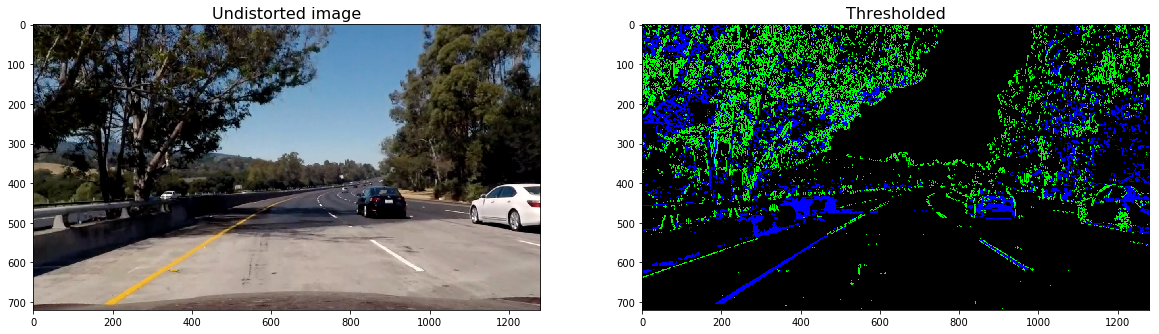

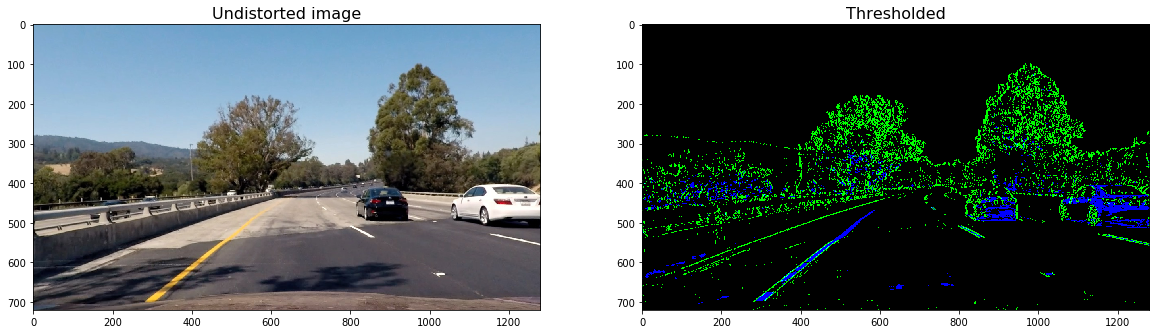

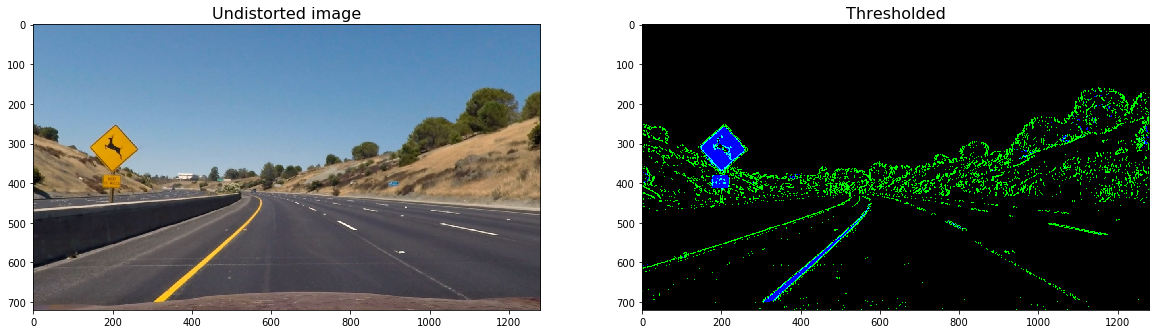

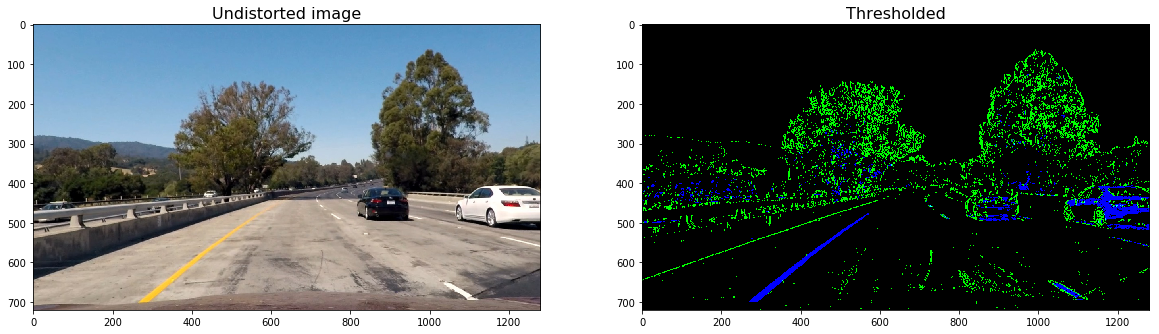

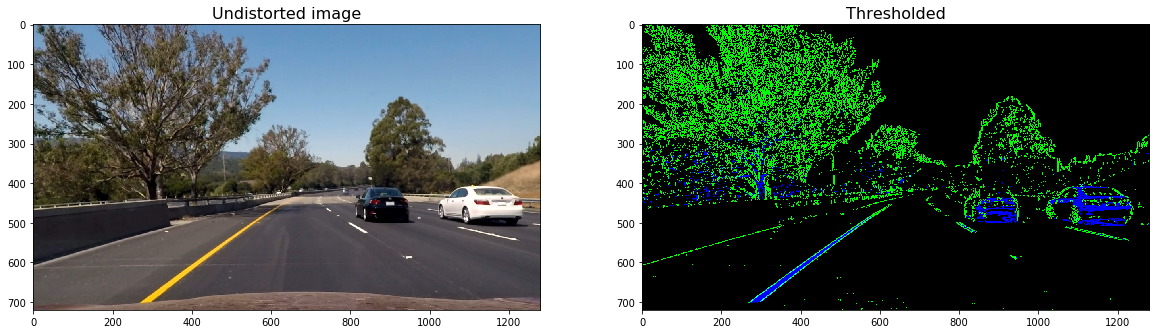

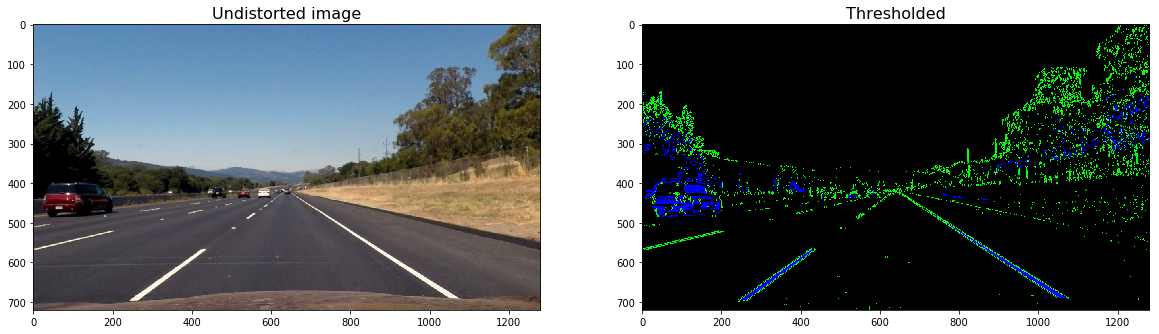

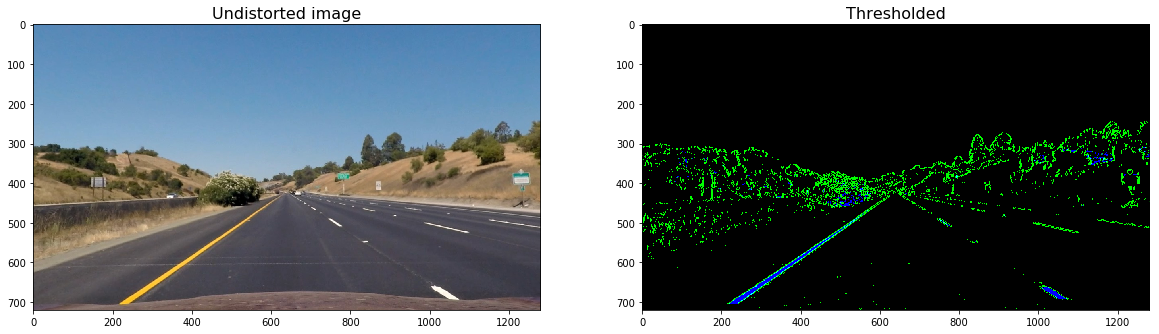

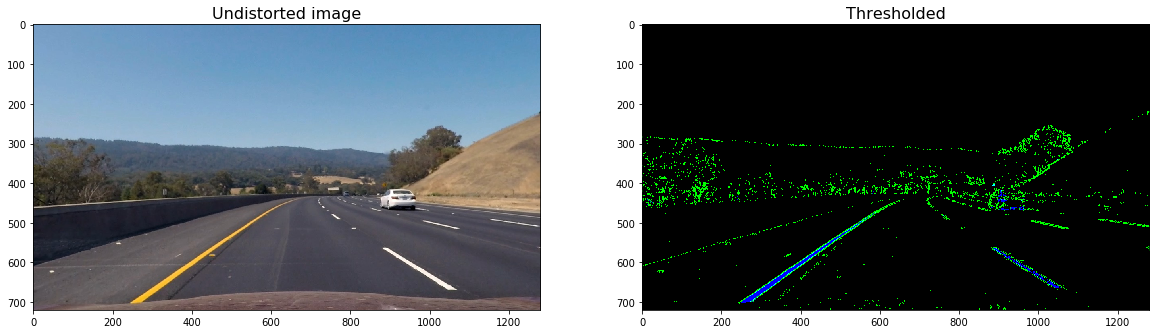

In [20]:
for fname in images:
    imgs = cv2.imread(fname)
    imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2RGB)
    undist = undistort(imgs, mtx, dist)
    _ = threshold(undist, show=True)